## README
To run the notebook you will need to mount your google drive and set the dataset_file_path to the location of the dataset.  You can also set this variable locally if you are running jupyter on your own machine.

The code will run faster if you use the sample dataset which is a 30% sample of the larger dataset.  Additional code can be found in the Code folder of this submission.


###Outline

*   Notebook Setup and Data Import
*   Dataset Analysis
*   Question 1
*   Question 2
*   Question 3



## Notebook Setup and Data Import

In [0]:
#import all libraries needed for the analysis

import pandas as pd                                     #general dataset manupliation
import numpy as np                                      #general dataset manupliation 
import os                                               #accessing datasets stored in the directory
import time                                             #used to time how long it takes steps to complete when not using verbose methods
import matplotlib.pyplot as plt                         #used for plotting the results
import seaborn as sns                                   #used for plotting the results 
from sklearn.model_selection import train_test_split    #used to create test, train, and validation sets
from sklearn.metrics import accuracy_score              #used for model evaluation
from sklearn.metrics import confusion_matrix            #used for model evaluation
from scipy import stats                                 #used for basic statistical analysis and correlation metrics

#models used for multiple sections
from sklearn import linear_model                        #used for baseline models
from sklearn.tree import DecisionTreeClassifier         #basic tree model used in classificaion problems
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

#specific to question 3
from imblearn.over_sampling import SMOTE                #used to balance the dataset with oversampling techniques
from collections import Counter                         #used to count the number of observations in each class

#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')
######################################
# You will need to mount your google drive and navigate to the path where you stored the data file
dataset_file_path = "/content/gdrive/My Drive/Colab Notebooks/AML_Final_Project/Data"
######################################

#matplot lib notebooks display command
%matplotlib inline

#SET OPTIONS
pd.options.display.float_format = '{:,.2f}'.format
#GLOBAL VARIABLES
cwd = os.getcwd()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#Load the dataset
'''
#full dataset 
dataset_df = pd.read_csv(dataset_file_path+'/invoices_with_acct_and_cases.csv', encoding='utf-8')
dataset_df.dtypes
'''
#sample dataset:
dataset_df = pd.read_csv(dataset_file_path+'/invoices_with_acct_and_cases_sample.csv', encoding='utf-8')
dataset_df.dtypes

INVOICE_ID                object
ACCT_ID                   object
CR_CHK_CD                 object
CUST_STAT                 object
PYDX_SCRE_NUM            float64
INDUSTRY_NM               object
CURR_NUM_LICENSES        float64
USAGE_SCORE              float64
EMP_CNT                  float64
CRNCY_ISO_CD              object
CUSTOMER_REVENUE         float64
DUE_MONTH                  int64
COLLECTOR                 object
COLLECTION_STATUS         object
HAS_TAX_EXEMP               bool
BILLING_COUNTRY           object
BILLING_LANGUAGE          object
PAYMENT_TERM              object
PAYMENT_TYPE              object
COMMENT_LENGTH             int64
HAS_30DAY_EXTXN             bool
PAST_DUE_FLG                bool
LATE_PMT_GT_30              bool
BAD_DEBT_FLAG             object
DAYS_TO_PAY                int64
CURRENCY_CODE             object
TOTAL_AMOUNT             float64
BALANCE_DUE                int64
WRITEOFF_AMT             float64
BILL_FREQ_NUM              int64
TOTAL_NUMB

## Custom Global Functions

In [0]:
#confusion matrix function
def plotConfusionMatrix(y_test, y_hat, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_hat, labels=classes)   
    
    if normalize == True:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(15,8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Loop over data dimensions and create text annotations.
    fmt = '.2%' if normalize == True else 'd'
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
            ax.set_ylim(len(cm)-0.5, -0.5)
    fig.tight_layout()
    return ax

# Dataset Analysis



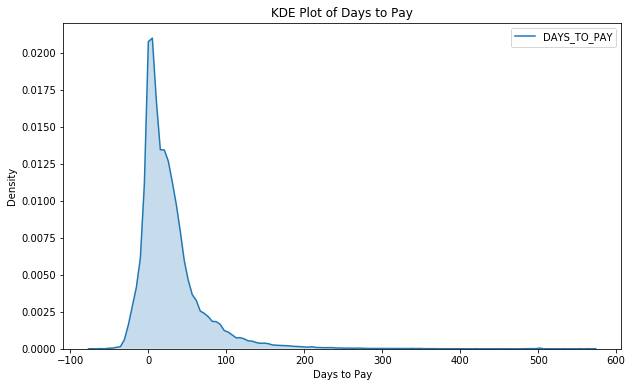

In [0]:
plt.figure(figsize=(10,6))
sns.kdeplot(dataset_df['DAYS_TO_PAY'], shade=True)
plt.title("KDE Plot of Days to Pay")
plt.xlabel("Days to Pay")
plt.ylabel("Density")
plt.show()

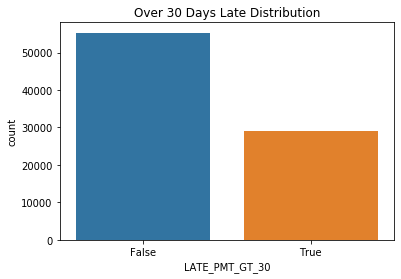

In [0]:
sns.countplot(dataset_df['LATE_PMT_GT_30'])
plt.xticks(rotation=0)
plt.title("Over 30 Days Late Distribution")
plt.show()

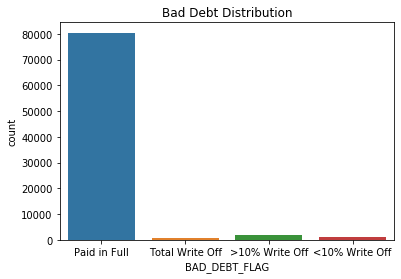

In [0]:
sns.countplot(dataset_df['BAD_DEBT_FLAG'])
plt.xticks(rotation=0)
plt.title("Bad Debt Distribution")
plt.show()

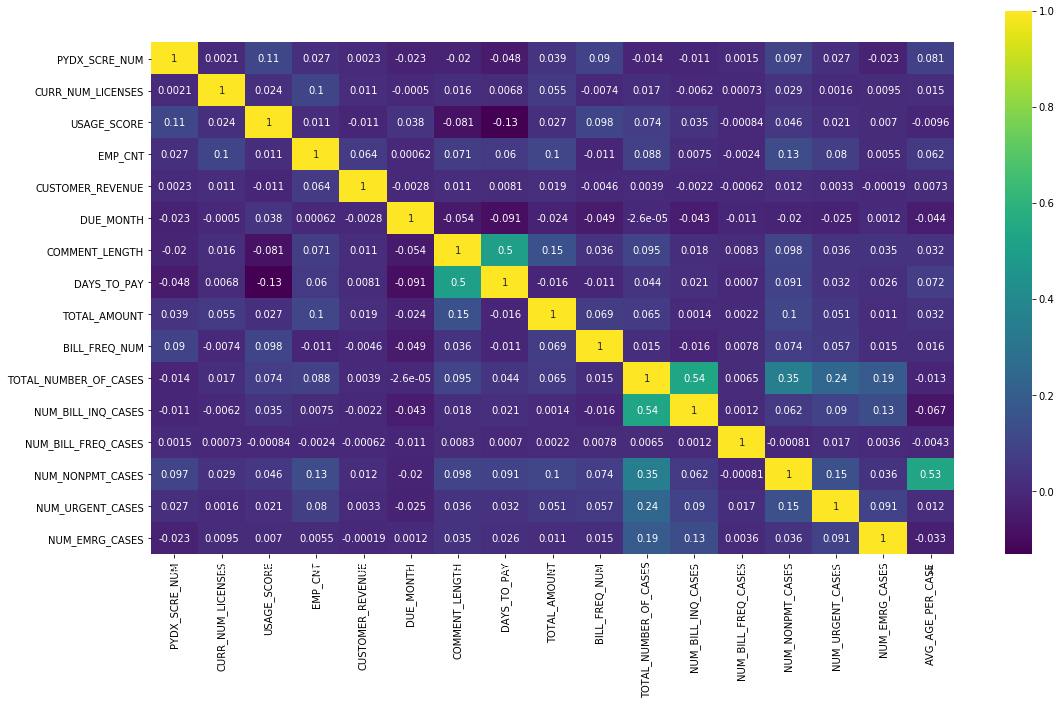

In [0]:
correlation_df = dataset_df.select_dtypes(include=['float64','int64'])
correlation_df = correlation_df.drop(columns=['BALANCE_DUE','WRITEOFF_AMT'])
correlation_df = correlation_df.corr()

plt.figure(figsize=(18,10))
hm = sns.heatmap(correlation_df, annot=True, cmap='viridis')
hm.set(ylim=(len(correlation_df)-2, -2)) #set to deal with matplotlib bug: https://github.com/matplotlib/matplotlib/issues/14751
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


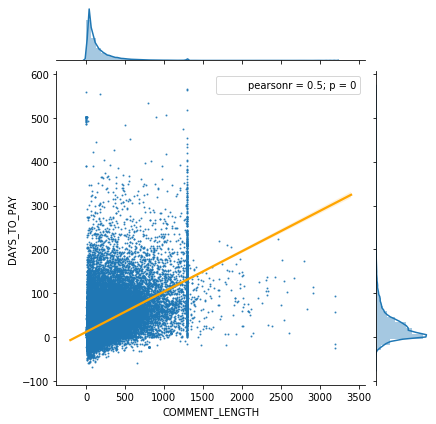

In [0]:
sns.jointplot(dataset_df['COMMENT_LENGTH'], dataset_df['DAYS_TO_PAY'], kind='reg'
              , stat_func=stats.pearsonr, joint_kws={'line_kws':{'color':'orange'}}, scatter_kws={"s": 1}) 
plt.show()

In [0]:
# "correlation" for categorical variables
# source: https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792

def cramers_v(X,y):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    confusion_matrix = pd.crosstab(X, y).values
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


cv = cramers_v(dataset_df['CR_CHK_CD'],dataset_df['LATE_PMT_GT_30'])
print(cv)

0.24238458192354687


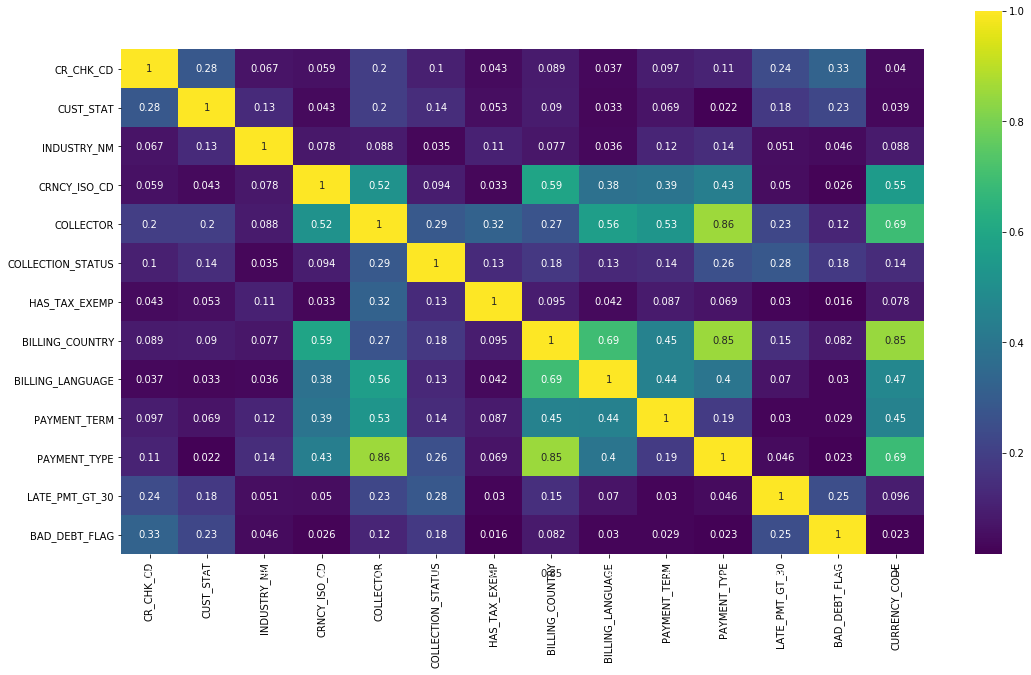

In [0]:
#source for plotting: https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

def cat_heatmap(dataframe):
    dataframe = dataframe.fillna('NA')
    columns = dataframe.columns
    corr = pd.DataFrame(index=columns, columns=columns)
    for i in range(0,len(columns)):
        for j in range(i,len(columns)):
            if i == j:
                corr[columns[i]][columns[j]] = 1.0
            else:
                cell = cramers_v(dataframe[columns[i]], dataframe[columns[j]])
                corr[columns[i]][columns[j]] = cell
                corr[columns[j]][columns[i]] = cell
    corr = corr.fillna(0.0)
    plt.figure(figsize=(18,10))
    hm = sns.heatmap(corr, annot=True, cmap='viridis')
    hm.set(ylim=(len(corr)-1, -1)) #set to deal with matplotlib bug: https://github.com/matplotlib/matplotlib/issues/14751
    plt.show()

cat_corr_df = dataset_df.select_dtypes(include=['O','bool'])
cat_corr_df = cat_corr_df.drop(columns=['INVOICE_ID','ACCT_ID','HAS_30DAY_EXTXN','PAST_DUE_FLG'])
cat_heatmap(cat_corr_df)

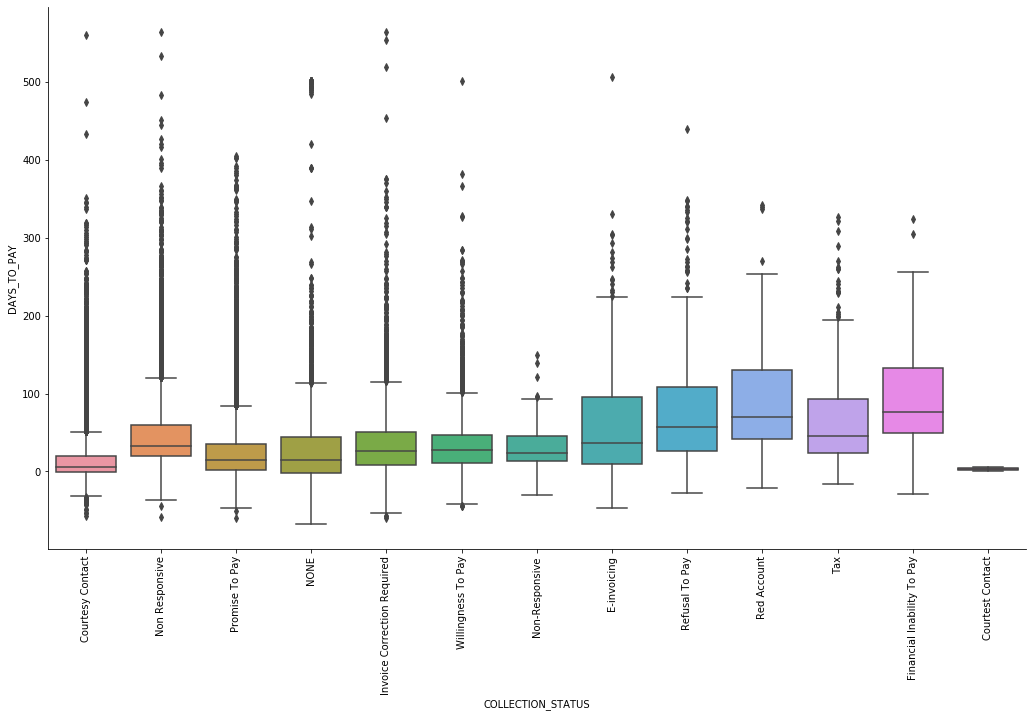

In [0]:
sns.catplot(x='COLLECTION_STATUS', y='DAYS_TO_PAY', kind="box", data=dataset_df, height=8.27, aspect=14.5/8.27)
plt.xticks(rotation=90)
plt.show()

# Question 1

In [0]:
import pandas as pd
import numpy as np
import os
import datetime
import time
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
######################################
# You will need to mount your google drive and navigate to the path where you stored the data file
dataset_file_path = "/content/gdrive/My Drive/Colab Notebooks/AML_Final_Project/Data"

In [0]:
data=pd.read_csv(dataset_file_path+'/invoices_with_acct_and_cases_sample.csv')
temp=data.copy(deep=True)

FileNotFoundError: ignored

In [0]:
data.dtypes

In [0]:
data.head()

In [0]:
Num_cols=data.select_dtypes(include=['float64','int64'])
# Num_cols=temp._get_numeric_data()*1

In [0]:
Num_cols.dtypes

In [0]:
Num_cols=Num_cols.drop(['BALANCE_DUE'],axis=1)
correlation=Num_cols.corr()
correlation

In [0]:
Num_cols.isna().any()

In [0]:
plt.figure(figsize=(20,10))
sns.heatmap(correlation, annot=True, cmap = 'viridis')

In [0]:
data=data.drop(['INVOICE_ID','DAYS_TO_PAY','ACCT_ID','BAD_DEBT_FLAG','WRITEOFF_AMT','COMMENT_LENGTH'],axis=1)
data=pd.get_dummies(data)
X=data.drop('LATE_PMT_GT_30',axis=1)
Y=data['LATE_PMT_GT_30']

In [0]:
data.select_dtypes(include=['float64','int64'])

In [0]:
Y=Y.replace(to_replace =[True,False] ,
                   value =["Late","Not Late"]) 

In [0]:
Y

In [0]:
df=pd.concat([Num_cols,Y],axis=1)

In [0]:
df

In [0]:
g=sns.pairplot(df,hue='LATE_PMT_GT_30')

In [0]:
df_cols=data.dtypes
df_cols.to_csv('new_dtypes.csv',header = True)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=0)

In [0]:
############ Feature Selection: Starts ######################

In [0]:
############ Variance Threshold: Starts ######################

In [0]:
from sklearn.feature_selection import VarianceThreshold

In [0]:
X_train

In [0]:
selector_vt = VarianceThreshold()

X_train_vt=selector_vt.fit_transform(X_train,y_train)

In [0]:
X_train_vt

In [0]:
X_train_vt.shape

In [0]:
############ Conversion from numpy to pandas with column names ################
X_train_vt=X_train[X_train.columns[selector_vt.get_support(indices=True)]]

In [0]:
X_train_vt

In [0]:
X_train_vt.shape

In [0]:
############ Columns having almost all the vales same , i.e. very low variance. Default threshold=0 #########
X_train[X_train.columns.difference(X_train_vt.columns)]

In [0]:
selector_vt = VarianceThreshold(threshold=0.005)

X_train_vt=selector_vt.fit_transform(X_train,y_train)

In [0]:
X_train_vt

In [0]:
X_train_vt.shape

In [0]:
############ Conversion from numpy to pandas with column names ################
X_train_vt=X_train[X_train.columns[selector_vt.get_support(indices=True)]]

In [0]:
X_train_vt

In [0]:
X_train_vt.shape

In [0]:
len(set(X_train.columns)-set(X_train_vt))

In [0]:
################# Columns having very little variance, threshold=0.005 ####################
X_train[list(set(X_train.columns)-set(X_train_vt))]

In [0]:
mask_vt=selector_vt.get_support()
mask_vt

In [0]:
X_test_vt = selector_vt.transform(X_test)
X_test_vt.shape

In [0]:
X_test_vt=X_test[X_test.columns[selector_vt.get_support(indices=True)]]
X_test_vt

In [0]:
############ Variance Threshold: Ends ######################

In [0]:
############ SelectPercentile: Starts ######################

In [0]:
from sklearn.feature_selection import SelectPercentile, chi2, f_classif, mutual_info_classif

In [0]:
selector_sp = SelectPercentile(f_classif, percentile=50)

X_train_sp=selector_sp.fit_transform(X_train_vt,y_train)
X_train_sp.shape

In [0]:
X_train_sp

In [0]:
############ Conversion from numpy to pandas with column names ################
X_train_sp=X_train_vt[X_train_vt.columns[selector_sp.get_support(indices=True)]]

In [0]:
X_train_sp

In [0]:
X_test_sp = selector_sp.transform(X_test_vt)
X_test_sp.shape

In [0]:
X_test_sp

In [0]:
############ Conversion from numpy to pandas with column names ################
X_test_sp=X_test_vt[X_test_vt.columns[selector_sp.get_support(indices=True)]]

In [0]:
X_test_sp

In [0]:
############ SelectPercentile: Ends ######################

In [0]:
############ Logistic Regression: Starts ######################

In [0]:
############ Original Features ######################

In [0]:
l=[0.1,1,5,10,15]
logreg_orig=LogisticRegressionCV(Cs=l,solver="saga",cv=5, max_iter=10000, penalty='l2')
logreg_orig.fit(X=X_train, y=y_train)
y_pred_orig=logreg_orig.predict(X_test)
score_orig = accuracy_score(y_test, y_pred_orig)
cf_orig=confusion_matrix(y_test, y_pred_orig)

In [0]:
score_orig

In [0]:
pd.DataFrame(cf_orig,
    columns=['Predicted Not Late', 'Predicted Late'],
    index=['Actual Not Late', 'Actual Late']
)

In [0]:
fig, ax = plot_confusion_matrix(conf_mat=cf_orig)
plt.show()

In [0]:
############ Selected Features ######################

l=[0.1,1,5,10,15]
logreg_sel=LogisticRegressionCV(Cs=l,solver="saga",cv=5, max_iter=10000, penalty='l2')
logreg_sel.fit(X=X_train_sp, y=y_train)
y_pred_sel=logreg_sel.predict(X_test_sp)
score_sel = accuracy_score(y_test, y_pred_sel)
cf_sel=confusion_matrix(y_test, y_pred_sel)

In [0]:
score_sel

In [0]:
pd.DataFrame(
    cf_sel,
    columns=['Predicted Not Late', 'Predicted Late'],
    index=['Actual Not Late', 'Actual Late']
)

In [0]:
fig, ax = plot_confusion_matrix(conf_mat=cf_sel)
plt.show()

In [0]:
############ Logistic Regression: Ends ######################

In [0]:
############ Decision Tree: Starts ######################

In [0]:
from sklearn import tree
import graphviz 

In [0]:
############ Original Features with full depth ######################
clf_orig = tree.DecisionTreeClassifier()
clf_orig.fit(X_train, y_train)
y_pred_dt_orig = clf_orig.predict(X_test)

acc_dt_orig=accuracy_score(y_test, y_pred_dt_orig)
acc_dt_orig

In [0]:
cf_dt_orig=confusion_matrix(y_test, y_pred_dt_orig)
cf_dt_orig

In [0]:
pd.DataFrame(
    cf_dt_orig,
    columns=['Predicted Not Late', 'Predicted Late'],
    index=['Actual Not Late', 'Actual Late']
)

In [0]:
fig, ax = plot_confusion_matrix(conf_mat=cf_dt_orig)
plt.show()

In [0]:
############ Testing with Train data will give 100% accuracy if we allow tree to branch to its full depth #############
#################### Original Features with full depth on train data ######################
clf_orig = tree.DecisionTreeClassifier()
clf_orig.fit(X_train, y_train)
y_pred_dt_orig_train = clf_orig.predict(X_train)

acc_dt_orig=accuracy_score(y_train, y_pred_dt_orig_train)
acc_dt_orig

In [0]:
############ Testing with Test data and depth = 1. Original Features with full depth on train data ######################
clf_orig = tree.DecisionTreeClassifier(max_depth=1)
clf_orig.fit(X_train, y_train)
y_pred_dt_orig_train = clf_orig.predict(X_test)

acc_dt_orig=accuracy_score(y_test, y_pred_dt_orig_train)
acc_dt_orig

In [0]:
columns=list(X_train.columns)

In [0]:
tree.plot_tree(clf_orig,feature_names =columns)

In [0]:
from sklearn.metrics import f1_score

f1_macro=f1_score(y_test, y_pred_dt_orig_train, average='macro') 
f1_macro

f1_micro=f1_score(y_test, y_pred_dt_orig_train, average='micro') 
f1_micro

f1_weighted=f1_score(y_test, y_pred_dt_orig_train, average='weighted')
f1_weighted

f1_average=f1_score(y_test, y_pred_dt_orig_train, average=None)
f1_average

In [0]:
############ Selected Features ######################
clf_sel = tree.DecisionTreeClassifier(max_depth=4)
clf_sel.fit(X_train_sp, y_train)
y_pred_dt_sel = clf_sel.predict(X_test_sp)

acc_dt_orig=accuracy_score(y_test, y_pred_dt_sel)
acc_dt_orig

In [0]:
cf_dt_sel=confusion_matrix(y_test, y_pred_dt_orig)
cf_dt_sel

In [0]:
pd.DataFrame(
    cf_dt_sel,
    columns=['Predicted Not Late', 'Predicted Late'],
    index=['Actual Not Late', 'Actual Late']
)

In [0]:
fig, ax = plot_confusion_matrix(conf_mat=cf_dt_sel)
plt.show()

In [0]:
columns_1=list(X_train_sp.columns)

tree.plot_tree(clf_sel,feature_names =columns_1)

In [0]:
############ Decision Tree: Ends ######################

In [0]:
############ Random Forest : Starts ######################

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [0]:
rf_dist={'max_depth':[3,5,10,None],
              'n_estimators':[10,100,200,300,400,500],
              'max_features':[2,3],
               'criterion':['gini','entropy'],
               'bootstrap':[True,False],
               'min_samples_leaf':[2,3],
           'min_samples_split':[2,4]
              }


In [0]:
############ Original Features with Randomized Search  ######################
rf_orig=RandomForestClassifier()

In [0]:
random_search_orig = RandomizedSearchCV(rf_orig, param_distributions=rf_dist,
                                   n_iter=10, cv=5, iid=False)
random_search_orig.fit(X=X_train, y=y_train)
y_pred_rf_orig=random_search_orig.predict(X_test)

In [0]:
acc_rf_orig=accuracy_score(y_test, y_pred_rf_orig)
acc_rf_orig

In [0]:
cf_rf_orig=confusion_matrix(y_test, y_pred_rf_orig)
cf_rf_orig

In [0]:
pd.DataFrame(
    cf_rf_orig,
    columns=['Predicted Not Late', 'Predicted Late'],
    index=['Actual Not Late', 'Actual Late']
)

In [0]:
fig, ax = plot_confusion_matrix(conf_mat=cf_rf_orig)
plt.show()

In [0]:
############ Selected Features with Randomized Search  ######################
rf_sel=RandomForestClassifier()
random_search_sel = RandomizedSearchCV(rf_sel, param_distributions=rf_dist,
                                   n_iter=20, cv=5, iid=False)
random_search_sel.fit(X=X_train_sp, y=y_train)
y_pred_rf_sel=random_search_sel.predict(X_test_sp)
acc_rf_sel=accuracy_score(y_test, y_pred_rf_sel)
acc_rf_sel

In [0]:
cf_rf_sel=confusion_matrix(y_test, y_pred_rf_sel)
cf_rf_sel

In [0]:
pd.DataFrame(
    cf_rf_sel,
    columns=['Predicted Not Late', 'Predicted Late'],
    index=['Actual Not Late', 'Actual Late']
)

In [0]:
fig, ax = plot_confusion_matrix(conf_mat=cf_rf_sel)
plt.show()

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
f1_macro=f1_score(y_test, y_pred_rf_sel, average='macro') 
f1_macro

f1_micro=f1_score(y_test, y_pred_rf_sel, average='micro') 
f1_micro

f1_weighted=f1_score(y_test, y_pred_rf_sel, average='weighted')
f1_weighted

f1_average=f1_score(y_test, y_pred_rf_sel, average=None)
f1_average

In [0]:
############ Selected Features with Grid Search  ######################
rf_sel_g=RandomForestClassifier()
random_search_sel_g = GridSearchCV(rf_sel_g, param_grid =rf_dist, cv=5, iid=False)
random_search_sel_g.fit(X=X_train_sp, y=y_train)
y_pred_rf_sel_g=random_search_sel.predict(X_test_sp)
acc_rf_sel_g=accuracy_score(y_test, y_pred_rf_sel_g)
acc_rf_sel_g

In [0]:
cf_rf_sel_grid=confusion_matrix(y_test, y_pred_rf_sel_g)
cf_rf_sel_grid

In [0]:
pd.DataFrame(
    cf_rf_sel_grid,
    columns=['Predicted Not Late', 'Predicted Late'],
    index=['Actual Not Late', 'Actual Late']
)

In [0]:
fig, ax = plot_confusion_matrix(conf_mat=cf_rf_sel_grid)
plt.show()

In [0]:
f1_macro=f1_score(y_test, y_pred_rf_sel_g, average='macro') 
f1_macro

f1_micro=f1_score(y_test, y_pred_rf_sel_g, average='micro') 
f1_micro

f1_weighted=f1_score(y_test, y_pred_rf_sel_g, average='weighted')
f1_weighted

f1_average=f1_score(y_test, y_pred_rf_sel_g, average=None)
f1_average

In [0]:
############ Random Forest : Ends ######################

In [0]:
############ SVC/SVM: Starts ######################

In [0]:
from sklearn.svm import SVC

In [0]:
################# Baseline model ####################

In [0]:
clf = SVC(gamma='auto')

In [0]:
clf.fit(X=X_train_sp, y=y_train)

In [0]:
y_pred_svc_sel=clf.predict(X_test_sp)
acc_svc_sel=accuracy_score(y_test, y_pred_svc_sel)
acc_svc_sel

In [0]:
clf_sel=confusion_matrix(y_test, y_pred_svc_sel)
clf_sel

In [0]:
pd.DataFrame(
    clf_sel,
    columns=['Predicted Not Late', 'Predicted Late'],
    index=['Actual Not Late', 'Actual Late']
)

In [0]:
fig, ax = plot_confusion_matrix(conf_mat=clf_sel)
plt.show()

In [0]:
############ Selected Features and GridSearchCV ######################

In [0]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100]},
                    {'kernel': ['linear'], 'C': [1, 10, 100]}]

In [0]:
clf_svc_sel_g = GridSearchCV(SVC(C=1), tuned_parameters,n_jobs=-1, cv=5,
                       scoring='f1_macro')


In [0]:
clf_svc_sel_g.fit(X=X_train_sp, y=y_train)

y_pred_svc_sel_g=clf_svc_sel_g.predict(X_test_sp)
acc_svc_sel_g=accuracy_score(y_test, y_pred_svc_sel_g)
acc_svc_sel_g

In [0]:
cf_svc_sel_g=confusion_matrix(y_test, y_pred_svc_sel_g)
cf_svc_sel_g

In [0]:
pd.DataFrame(
    cf_svc_sel_g,
    columns=['Predicted Not Late', 'Predicted Late'],
    index=['Actual Not Late', 'Actual Late']
)

In [0]:
fig, ax = plot_confusion_matrix(conf_mat=cf_svc_sel_g)
plt.show()

In [0]:
############ SVC/SVM: Ends ######################

# Question 2

Code and figures for question 2 is in the folder Q2_code. Linear regression was run locally, SVR was run on the SICE SILO machine.

# Question 3

In [0]:
def pre_process(df, dropcols=None):
    '''
    The pre_process function that will return a transformed dataframe
    Notes:
        1) dropcols should be a list
        2) integer varibles are transformed using mean normalization
    '''
    #drop columns input by the user
    if dropcols is not None:
        df = df.drop(columns=dropcols)
    
    #loop through remaining columns and apply the appropreate transform
    for i in df.columns:
        #mean normalization for int variables
        if df[i].dtype == "int64" or df[i].dtype == 'float64':
            mean = df[i].mean()
            if (df[i].max() - df[i].min()) == 0:
                denom = 1
            else:
                denom = (df[i].max() - df[i].min())
            df[i] = df[i].apply(lambda x: float(x - mean) / denom)
        #convert bool values to 1 and 0
        elif df[i].dtype == "bool":
            df[i] = df[i].map({True: 1, False: 0})
        #convert True and False to 1 and 0
        elif df[i].dtype == "object" and "True" in set(df[i].tolist()) and "False" in set(df[i].tolist()): 
            df[i] = df[i].map({'True': 1, 'False': 0})
        elif df[i].dtype == "object":
            df = pd.get_dummies(df, columns=[i], prefix=[i], dtype="int8") #, sparse=True
        
    return df

clean_df = pre_process(dataset_df, dropcols=['BAD_DEBT_FLAG','INVOICE_ID','ACCT_ID','DAYS_TO_PAY','WRITEOFF_AMT',
                                              'BALANCE_DUE','NUM_NONPMT_CASES','HAS_30DAY_EXTXN',
                                              'COLLECTION_STATUS','CRNCY_ISO_CD'])
print(clean_df.shape)

(84253, 436)


In [0]:
X = clean_df
y = dataset_df['BAD_DEBT_FLAG']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

print(X_train.shape)
print(y_train.shape)

(53921, 436)
(53921,)


In [0]:
print('Original dataset shape %s' % Counter(y_train))

#Need to balance the dataset
sm = SMOTE(sampling_strategy='not majority', random_state=7)
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))
print(X_res.shape)

Original dataset shape Counter({'Paid in Full': 51462, '>10% Write Off': 1309, '<10% Write Off': 725, 'Total Write Off': 425})
Resampled dataset shape Counter({'Total Write Off': 51462, 'Paid in Full': 51462, '>10% Write Off': 51462, '<10% Write Off': 51462})
(205848, 436)


Model with Regularization Coef 0.1 completed in 57.944sec | Accuracy = 70.03%
Model with Regularization Coef 0.5 completed in 155.517sec | Accuracy = 69.85%
Model with Regularization Coef 1 completed in 216.446sec | Accuracy = 69.82%
Model with Regularization Coef 5 completed in 407.338sec | Accuracy = 69.79%
Model with Regularization Coef 10 completed in 601.139sec | Accuracy = 69.75%
Model with Regularization Coef 20 completed in 1029.74sec | Accuracy = 69.77%


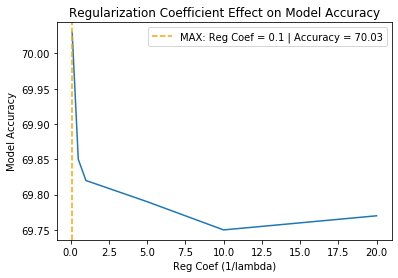

In [0]:
regCoef_list = [0.1,0.5,1,5,10,20] 
accuracy_list = []

for c in regCoef_list:
    start = time.process_time()
    logreg = linear_model.LogisticRegression(solver="saga", C=c, max_iter=1000, penalty='l2', multi_class='multinomial', verbose=0)
    logreg.fit(X=X_res, y=y_res)
    score = logreg.score(X_valid, y_valid)
    accuracy_list.append(round(score*100,2))
    end = time.process_time()
    print('Model with Regularization Coef '+str(c)+' completed in '+str(round(end-start,3))+'sec | Accuracy = '+str(round(score*100,2))+'%')

plt.plot(regCoef_list, accuracy_list)
plt.axvline(x=regCoef_list[accuracy_list.index(max(accuracy_list))], color='orange', linestyle='--', 
            label='MAX: Reg Coef = {}'.format(regCoef_list[accuracy_list.index(max(accuracy_list))])+
            ' | Accuracy = {}'.format(max(accuracy_list)))
plt.title("Regularization Coefficient Effect on Model Accuracy")
plt.xlabel("Reg Coef (1/lambda)")
plt.ylabel("Model Accuracy")
plt.legend()
plt.show()

In [0]:
#run model with test data
logreg = linear_model.LogisticRegression(solver="saga", C=1, max_iter=1000, penalty='l2', multi_class='multinomial', verbose=1)
logreg.fit(X=X_res, y=y_res)

y_hat = logreg.predict(X_test)
score = accuracy_score(y_test, y_hat)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model Accuracy: 69.53


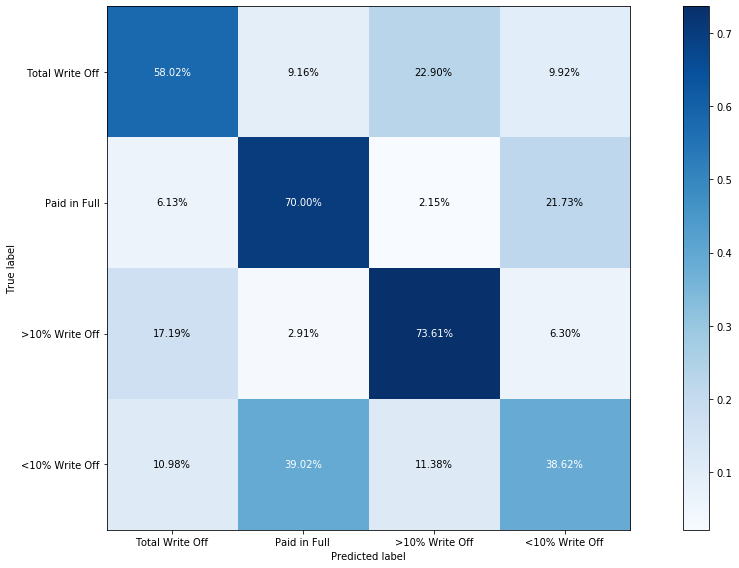

In [0]:
print('Model Accuracy: '+str(round(score*100,2)))
plotConfusionMatrix(y_test, y_hat, classes=['Total Write Off','Paid in Full','>10% Write Off','<10% Write Off'], normalize=True)
plt.show()

Model with max depth 3 completed in 6.498sec | Accuracy = 66.72%
Model with max depth 5 completed in 9.501sec | Accuracy = 77.06%
Model with max depth 8 completed in 12.897sec | Accuracy = 76.5%
Model with max depth 10 completed in 14.683sec | Accuracy = 85.56%
Model with max depth 12 completed in 16.304sec | Accuracy = 83.66%
Model with max depth 15 completed in 18.118sec | Accuracy = 87.64%
Model with max depth 20 completed in 20.719sec | Accuracy = 91.04%
Model with max depth 25 completed in 22.883sec | Accuracy = 92.56%
Model with max depth 50 completed in 28.863sec | Accuracy = 93.54%
Model with max depth 100 completed in 33.106sec | Accuracy = 93.81%


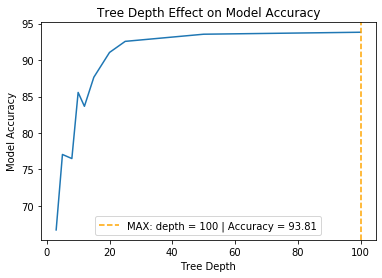

In [0]:
depth_list = [3,5,8,10,12,15,20,25,50,100] #focusing around 10 layers deep as that provides the best accuracy 
accuracy_list = []

for d in depth_list:
    start = time.process_time()
    decision_tree = DecisionTreeClassifier(max_depth=d)
    decision_tree = decision_tree.fit(X_res, y_res)
    score = decision_tree.score(X_valid, y_valid)
    accuracy_list.append(round(score*100,2))
    end = time.process_time()
    print('Model with max depth '+str(d)+' completed in '+str(round(end-start,3))+'sec | Accuracy = '+str(round(score*100,2))+'%')

plt.plot(depth_list, accuracy_list)
plt.axvline(x=depth_list[accuracy_list.index(max(accuracy_list))], color='orange', linestyle='--', 
            label='MAX: depth = {}'.format(depth_list[accuracy_list.index(max(accuracy_list))])+
            ' | Accuracy = {}'.format(max(accuracy_list)))
plt.title("Tree Depth Effect on Model Accuracy")
plt.xlabel("Tree Depth")
plt.ylabel("Model Accuracy")
plt.legend()
plt.show()

Test Accuracy: 85.1%


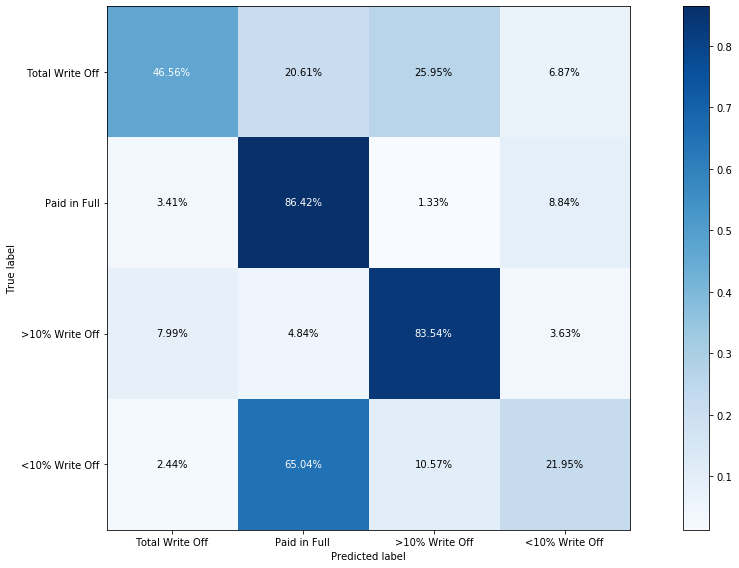

In [0]:
#train model base on best parameters from training / validation phase
decision_tree = DecisionTreeClassifier(max_depth=10)
decision_tree.fit(X_res, y_res)

#print test accuracy and plot confusion matrix
print('Test Accuracy: '+str(round(decision_tree.score(X_test, y_test)*100,2))+'%')
y_hat = decision_tree.predict(X_test)
plotConfusionMatrix(y_test, y_hat, classes=['Total Write Off','Paid in Full','>10% Write Off','<10% Write Off'],
                    normalize=True)
plt.show()

In [0]:
from sklearn.ensemble import AdaBoostClassifier
start = time.process_time()
abc = AdaBoostClassifier(n_estimators=200, base_estimator=DecisionTreeClassifier(max_depth=1))
abc.fit(X_res, y_res)
print('Model fit complete')
score = abc.score(X_valid, y_valid)
end = time.process_time()
print('Ada boost model completed in '+str(round(end-start,3))+'sec | Train Accuracy = '+str(round(score*100,2))+'%')

#gbc = GradientBoostingClassifier(n_estimators=250, learning_rate=0.01, max_depth=10, verbose=1, n_iter_no_change=1, max_features='sqrt') 
#gbc.fit(X_res, y_res)

#print test accuracy and plot confusion matrix
print('Test Accuracy: '+str(round(abc.score(X_test, y_test)*100,2))+'%')
y_hat = abc.predict(X_test)
plotConfusionMatrix(y_test, y_hat, classes=['Total Write Off','Paid in Full','>10% Write Off','<10% Write Off'], normalize=True)
plt.show()